# LSTM neural network for time series prediction

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import trange
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load the data

We load and plot Tesla stock data from 2010 to 2020

In [2]:
tesla_data = pd.read_csv('TSLA_2010_2020.csv')
tesla_data = tesla_data.drop(['Date','Open','High','Low','Close','Volume'],axis = 1)
total_days = tesla_data.shape[0]
tesla_data.head()

,Adj Close
0,23.889999
1,23.830000
2,21.959999
3,19.200001
4,16.110001


<Figure size 432x288 with 0 Axes>

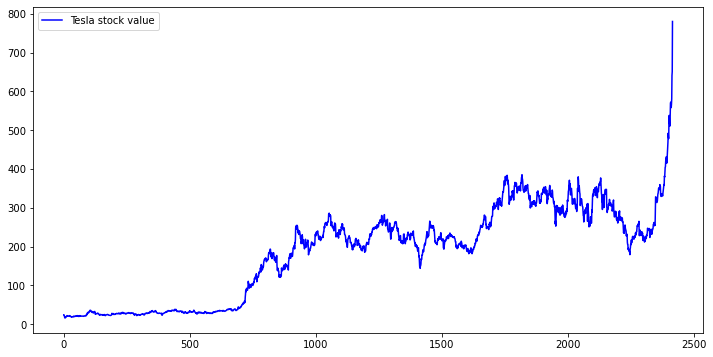

In [3]:
plt.clf()
plt.figure(figsize=(12,6))
plt.plot(tesla_data, label='Tesla stock value', c = 'b')
plt.legend()
plt.show() 

# Create a LSTM neural network

We define a class LSTM_nn which is a neural network with LSTM layers

In [4]:
class LSTM_nn(nn.Module):
    def __init__(self,input_size, num_layers, hidden_size, seq_length):
        super(LSTM_nn, self).__init__()
        #Attributes from nn.Module
        self.input_size = input_size #input size
        self.num_layers = num_layers #number of layers
        self.hidden_size = hidden_size #hidden state
        
        #New attributes
        self.seq_length = seq_length #sequence length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first = True) #lstm
        
        self.fc =  nn.Linear(hidden_size, 1) #fully connected linear


    def forward(self,X):
        h_0 = Variable(torch.zeros(self.num_layers, X.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, X.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(X, (h_0, c_0)) #lstm with input, hidden, and internal state
        final_state = hn.view(self.num_layers, X.size(0), self.hidden_size)[-1]
                
        # Propagate input through fully connected linear neuron
        out = self.fc(final_state)
        
        return out
    
    
    def _train(self, num_epochs, learning_rate, criterion, X_train, y_train, X_test, y_test):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate) 
        t = trange(num_epochs+1)
        for epoch in t:
            #Pass through the neural network
            train_outputs = self.forward(X_train) 
            test_outputs = self.forward(X_test) 

            #Reset gradients to zero  
            optimizer.zero_grad() 

            train_loss = criterion(train_outputs, y_train)
            test_loss = criterion(test_outputs,y_test)

            #Backprogagation step
            train_loss.backward()

            #Update weights and bias of the network
            optimizer.step()

            #Print train and test loss
            t.set_description("Epoch: %d, Train loss: %1.5f, Test loss: %1.5f" % (epoch, train_loss.item(),test_loss.item()))
    
    def get_horizon_predictions(self, X_data, y_data, scaler, horizon):
        total_days = X_data.shape[0]
        predictions = np.ndarray(shape=(total_days-horizon+1,horizon), dtype=float)
        for i in range(total_days-horizon+1):
            X_temp = X_data[i].unsqueeze(0)
            for j in range(horizon):
                next_prediction = self(X_temp)
                predictions[i,j] = scaler.inverse_transform(next_prediction.detach().numpy()).squeeze()
                X_temp_shifted = X_temp[:,1:].reshape((1,self.seq_length-1,self.input_size))
                X_temp = torch.cat((X_temp_shifted,next_prediction.unsqueeze(0)),1)
        return predictions
    
    def get_accuracy(self, X_data, y_data, naive_prediction, scaler, last_day):
        lstm_prediction = scaler.inverse_transform(self(X_data).detach().numpy())
        real_values = scaler.inverse_transform(y_data.numpy())

        naive_error = mean_squared_error(real_values[:last_day:1],naive_prediction[:last_day:1])
        lstm_error = mean_squared_error(real_values[:last_day:1],lstm_prediction[:last_day:1])

        naive_r2 = r2_score(real_values[:last_day:1], naive_prediction[:last_day:1])
        lstm_r2 = r2_score(real_values[:last_day:1], lstm_prediction[:last_day:1])

        print('Mean squared error up to the ' + str(last_day) + ' day using the naive prediction : ' + str(naive_error))
        print('Mean squared error up to the ' + str(last_day) + ' day using the lstm prediction : ' + str(lstm_error))
        print('R2 up to the ' + str(last_day) + ' day using the naive prediction : ' + str(naive_r2))
        print('R2 up to the ' + str(last_day) + ' day using the lstm prediction : ' + str(lstm_r2))
    
    def get_accuracy_with_horizon(self, X_data, y_data, naive_prediction_without_horizon, scaler, last_day, horizon):
        lstm_prediction = self.get_horizon_predictions(X_data, y_data, scaler, horizon)
        total_days = lstm_prediction.shape[0]
        real_values_without_horizon = scaler.inverse_transform(y_data.numpy())
        real_values = np.ndarray(shape=(total_days,horizon), dtype=float)
        naive_prediction = np.ndarray(shape=(total_days,horizon), dtype=float)
        for i in range(total_days):
            for j in range(horizon):
                real_values[i,j] = real_values_without_horizon[i+j]
                naive_prediction[i,j] = naive_prediction_without_horizon[i]
                
        naive_error = mean_squared_error(real_values[:last_day:1].flatten(),naive_prediction[:last_day:1].flatten())
        lstm_error = mean_squared_error(real_values[:last_day:1].flatten(),lstm_prediction[:last_day:1].flatten())

        naive_r2 = r2_score(real_values[:last_day:1].flatten(), naive_prediction[:last_day:1].flatten())
        lstm_r2 = r2_score(real_values[:last_day:1].flatten(), lstm_prediction[:last_day:1].flatten())

        print('Mean squared error up to the ' + str(last_day) + ' day using the naive prediction : ' + str(naive_error))
        print('Mean squared error up to the ' + str(last_day) + ' day using the lstm prediction : ' + str(lstm_error))
        print('R2 up to the ' + str(last_day) + ' day using the naive prediction : ' + str(naive_r2))
        print('R2 up to the ' + str(last_day) + ' day using the lstm prediction : ' + str(lstm_r2))
        
    def plot(self, X_data, y_data, scaler):
        lstm_prediction = scaler.inverse_transform(self(X_data).detach().numpy())
        real_values = scaler.inverse_transform(y_data.numpy())
        plt.plot(real_values, label='Actual value', c = 'b')
        plt.plot(lstm_prediction, label='LSTM Prediction', c = 'r')
        plt.legend()
        plt.show()
        
    def plot_with_horizon(self, X_data, y_data, scaler, horizon, drawing_jump):
        colors = ['r','g','k','y']
        real_values = scaler.inverse_transform(y_data.numpy())
        predictions = self.get_horizon_predictions(X_data, y_data, scaler, horizon)
        plt.plot(real_values, label='Actual value', c = 'b')
        for i in range(0,predictions.shape[0], drawing_jump):
            plt.plot(np.arange(i,i+horizon),predictions[i], c = colors[int(i/drawing_jump) % len(colors)])
        plt.legend()
        plt.show()

# Data processing

We define a sliding windows function that takes the previous days as features and the current day as target. It also computes a moving average to reduce noise.

In [5]:
def average(l,average_size):
    res = np.zeros(len(l)-average_size+1)
    for i in range(len(l)-average_size+1):
        res[i] = (sum(l[i:i+average_size])/len(l[i:i+average_size]))
    return res

In [6]:
def sliding_windows(data, seq_length, average_size):
    X = []
    y = []
    data = average(np.array(data).reshape(-1),average_size).reshape(-1,1)
    for i in range(len(data)-seq_length):
        Xi = data[i:(i+seq_length)]
        yi = data[i+seq_length]
        X.append(Xi)
        y.append(yi)
    return np.array(X),np.array(y)

We define a process function

In [7]:
def process_data(data, seq_length,average_size, train_proportion, scaler):
    data = np.array(data)
    
    #Fitting on training data
    train_size = int(len(data) * train_proportion)
    scaler.fit(data[0:train_size])
    
    #Transforming all data
    data_normalized = scaler.transform(data)
    X,y = sliding_windows(data_normalized,seq_length, average_size)
    
    #Raw Target
    y_raw = data_normalized[seq_length-1+average_size:]
    y_raw = Variable(torch.Tensor(y_raw))
    
    #All data
    X_data = Variable(torch.Tensor(X))
    y_data = Variable(torch.Tensor(y))
    
    #Training 
    X_train = Variable(torch.Tensor(X[0:train_size]))
    y_train = Variable(torch.Tensor(y[0:train_size]))
    
    #Testing
    X_test = Variable(torch.Tensor(X[train_size:len(X)]))
    y_test = Variable(torch.Tensor(y[train_size:len(X)]))

    return y_raw, X_data, y_data, X_train, y_train, X_test, y_test

We define a process function with a difference step to avoid prediction based on autocorrelation

In [8]:
def process_data_diff(data, seq_length, average_size, train_proportion, scaler):
    data = np.array(data)
    
    #Differencing the time series
    data_diff = np.diff(data.reshape(data.shape[0])).reshape(-1,1)

    #Fitting on training data
    train_size = int(len(data_diff) * train_proportion)    
    scaler.fit(data_diff[0:train_size])
    
    #Transforming all data
    data_normalized = scaler.transform(data_diff)
    X,y = sliding_windows(data_normalized,seq_length,average_size)
    
    #Raw Target
    y_raw = data_normalized[seq_length-1+average_size:]
    y_raw = Variable(torch.Tensor(y_raw))
    
    #All data
    X_data = Variable(torch.Tensor(X))
    y_data = Variable(torch.Tensor(y))
    
    #Training 
    X_train = Variable(torch.Tensor(X[0:train_size]))
    y_train = Variable(torch.Tensor(y[0:train_size]))
        
    #Test
    X_test = Variable(torch.Tensor(X[train_size:len(X)]))
    y_test = Variable(torch.Tensor(y[train_size:len(X)]))

    return y_raw, X_data, y_data, X_train, y_train, X_test, y_test

We process our data two times

In [9]:
seq_length = 15
average_size = 7
train_proportion = 2/3
scaler1 = MinMaxScaler(feature_range=(-1, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))

y_raw1, X_data1, y_data1, X_train1, y_train1, X_test1, y_test1 = process_data(tesla_data, seq_length, average_size, train_proportion, scaler1)
y_raw2, X_data2, y_data2, X_train2, y_train2, X_test2, y_test2 = process_data_diff(tesla_data, seq_length, average_size, train_proportion, scaler2)

# Model definition/training

We create two recurrent neural network with our LSTM_nn class

In [10]:
my_model1 = LSTM_nn(input_size = 1, num_layers = 2, hidden_size = 21, seq_length = seq_length)
my_model2 = LSTM_nn(input_size = 1, num_layers = 2, hidden_size = 21, seq_length = seq_length)

We train our first model with the raw data

In [11]:
num_epochs = 1000
learning_rate = 0.001
criterion = nn.MSELoss()
my_model1._train(num_epochs, learning_rate, criterion, X_train1, y_train1, X_test1, y_test1)

Epoch: 1000, Train loss: 0.00063, Test loss: 0.03638: 100%|██████████| 1001/1001 [01:47<00:00,  9.30it/s]


We train our second model with the differenciated data

In [12]:
num_epochs = 1000
learning_rate = 0.001
criterion = nn.MSELoss()    
my_model2._train(num_epochs, learning_rate, criterion, X_train2, y_train2, X_test2, y_test2)

Epoch: 1000, Train loss: 0.00090, Test loss: 0.00477: 100%|██████████| 1001/1001 [01:52<00:00,  8.91it/s]


Use this to save our models parameters for future use

In [13]:
filepath1 = 'lstm1'
filepath2 = 'lstm2'
torch.save(my_model1.state_dict(), filepath1)
torch.save(my_model2.state_dict(), filepath2)

Use this to load saved parameters

In [12]:
filepath1 = 'lstm1'
filepath2 = 'lstm2'
my_model1.load_state_dict(torch.load(filepath1))
my_model2.load_state_dict(torch.load(filepath2))

<All keys matched successfully>

# Evaluating/Plotting the results

We compare the accuracy of our predictions with the naive prediction $\hat{y}(t+1 | t) = y(t)$ by computing a MSE loss and a $R^2$

In [13]:
last_day = 2400
print('First model accuracy :')
naive_prediction1 = scaler1.inverse_transform(X_data1.numpy()[:,my_model1.seq_length-1])
my_model1.get_accuracy(X_data1, y_data1, naive_prediction1, scaler1, last_day)
print('\n')
print('Second model accuracy :')
naive_prediction2 = np.zeros(y_data2.size(0))
my_model2.get_accuracy(X_data2, y_data2, naive_prediction2, scaler2, last_day)

First model accuracy :
Mean squared error up to the 2400 day using the naive prediction : 6.5070815
Mean squared error up to the 2400 day using the lstm prediction : 151.49716
R2 up to the 2400 day using the naive prediction : 0.9995270534913108
R2 up to the 2400 day using the lstm prediction : 0.988988911208269


Second model accuracy :
Mean squared error up to the 2400 day using the naive prediction : 6.509801450485878
Mean squared error up to the 2400 day using the lstm prediction : 1.696614
R2 up to the 2400 day using the naive prediction : -0.009729191623648159
R2 up to the 2400 day using the lstm prediction : 0.7368397911867977


We plot our predicitons

<Figure size 432x288 with 0 Axes>

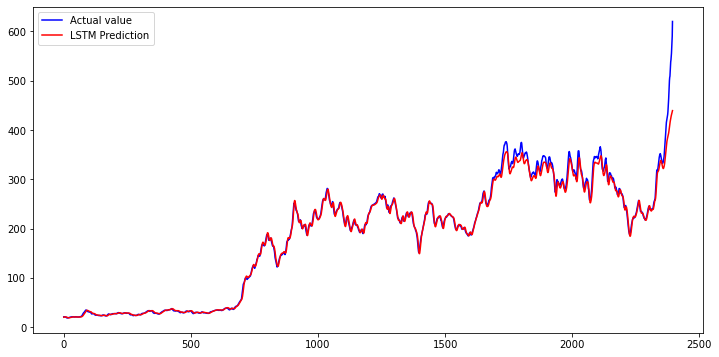

In [14]:
plt.clf()
plt.figure(figsize=(12,6))
my_model1.plot(X_data1, y_data1, scaler1)

<Figure size 432x288 with 0 Axes>

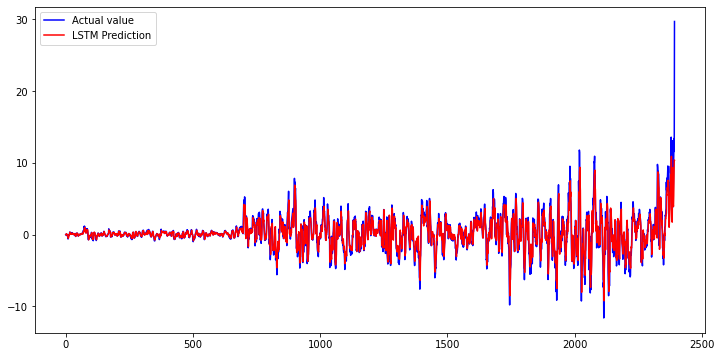

In [15]:
plt.clf()
plt.figure(figsize=(12,6))
my_model2.plot(X_data2, y_data2, scaler2)

Interpretation:

We notice on the MSE that the first model performs poorly as it is worse that the naive prediction. We should not consider the high value of $R^2$ as an evidence of quality of our model. The $R^2$ is high because our time series has a high autocorrelation. On the other hand, the second model (which use the differencing time series) performs well with a $R^2 \simeq 0.73$ while the naive prediction has a $R^2 \simeq -0.01$. We note that we applied a moving average step on our data and if we compare our predictions with the raw target values, we get poor results.

In [16]:
print('Second model accuracy with the raw data:')
naive_prediction2 = np.zeros(y_data2.shape[0])
my_model2.get_accuracy(X_data2, y_raw2, naive_prediction2, scaler2, last_day)

Second model accuracy with the raw data:
Mean squared error up to the 2400 day using the naive prediction : 50.411859994744155
Mean squared error up to the 2400 day using the lstm prediction : 52.72759
R2 up to the 2400 day using the naive prediction : -0.002001292492675555
R2 up to the 2400 day using the lstm prediction : -0.048029360825675216


<Figure size 432x288 with 0 Axes>

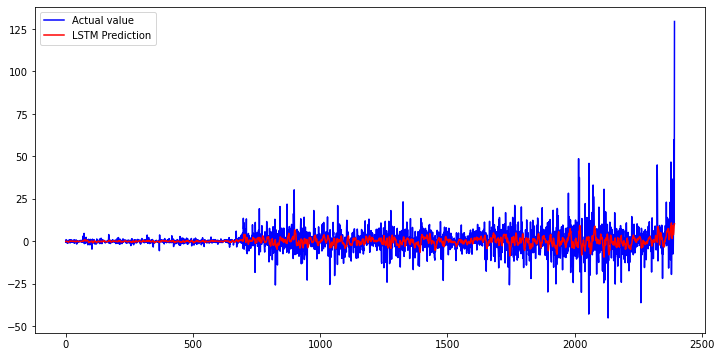

In [17]:
plt.clf()
plt.figure(figsize=(12,6))
my_model2.plot(X_data2, y_raw2, scaler2)

# Covid-19 data

We load the covid-19 data from France

In [18]:
covid_data = pd.read_csv('covid_data.csv')
covid_data = covid_data.loc[covid_data['Country'] == 'France']
covid_data = covid_data[['Confirmed']]
covid_data.tail()

,Confirmed
38866,6989613
38867,6994319
38868,6995628
38869,7002393
38870,7008228


<Figure size 432x288 with 0 Axes>

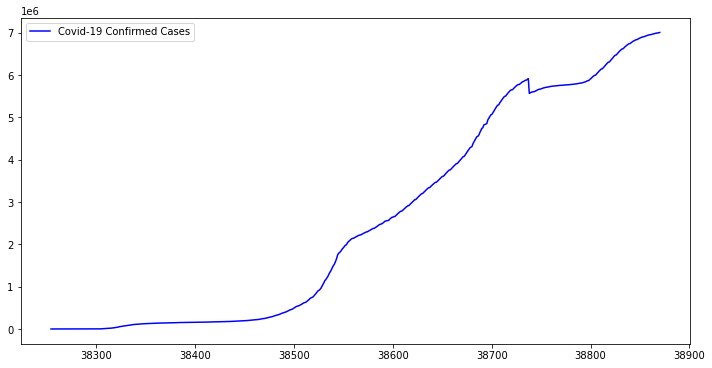

In [19]:
plt.clf()
plt.figure(figsize=(12,6))
plt.plot(covid_data, label='Covid-19 Confirmed Cases', c = 'b')
plt.legend()
plt.show() 

We process our data

In [20]:
seq_length = 15
average_size = 3
train_proportion = 2/3
scaler = MinMaxScaler(feature_range=(-1, 1))
y_raw, X_data, y_data, X_train, y_train, X_test, y_test = process_data_diff(covid_data, seq_length, average_size, train_proportion, scaler)

In [21]:
my_model = LSTM_nn(input_size = 1, num_layers = 2, hidden_size = 21, seq_length = seq_length)

In [65]:
num_epochs = 2000
learning_rate = 0.01
criterion = nn.MSELoss()
my_model._train(num_epochs, learning_rate, criterion, X_train, y_train, X_test, y_test)

Epoch: 2000, Train loss: 0.00010, Test loss: 0.06899: 100%|██████████| 2001/2001 [01:58<00:00, 16.85it/s]


In [22]:
filepath3 = 'lstm3'
torch.save(my_model.state_dict(), filepath3)

In [22]:
filepath3 = 'lstm3'
my_model.load_state_dict(torch.load(filepath3))

<All keys matched successfully>

<Figure size 432x288 with 0 Axes>

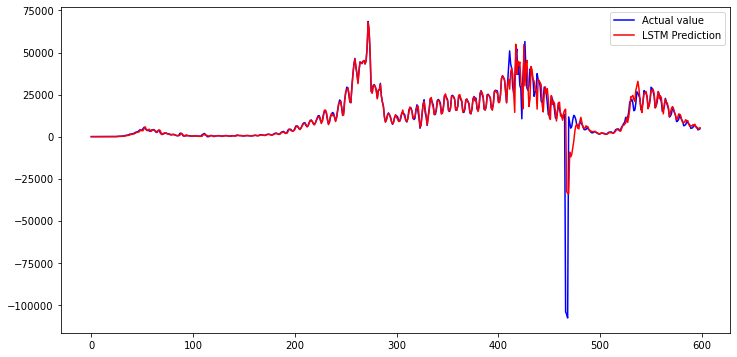

In [23]:
plt.clf()
plt.figure(figsize=(12,6))
my_model.plot(X_data, y_data, scaler)

<Figure size 432x288 with 0 Axes>

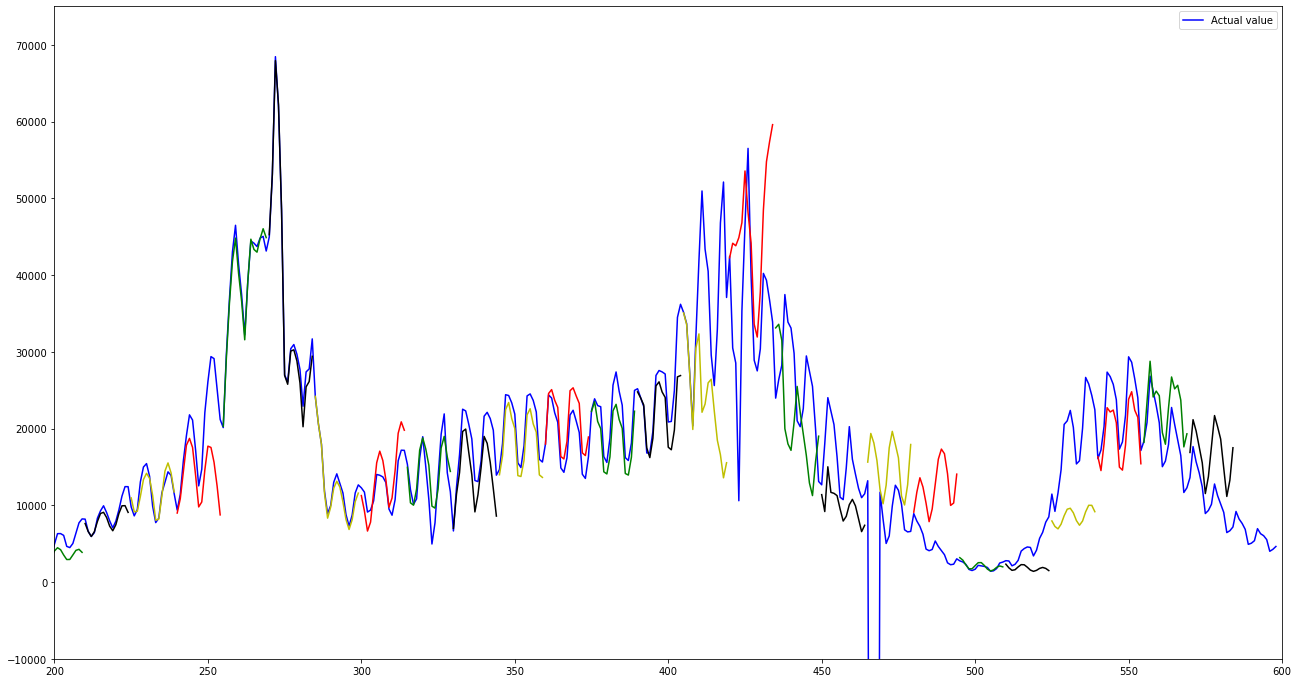

In [30]:
horizon = 15
drawing_jump = 15
plt.clf()
plt.figure(figsize=(22,12))
plt.axis([200, 600, -10000, 75000])
my_model.plot_with_horizon(X_data, y_data, scaler, horizon, drawing_jump)

In [29]:
last_day = y_data.shape[0]
horizon_1 = 1
horizon_2 = 7
horizon_3 = 15
naive_prediction_without_horizon = np.zeros(y_data.shape[0])
print('Model accuracy with horizon = 1: \n')
my_model.get_accuracy_with_horizon(X_data, y_data, naive_prediction_without_horizon, scaler, last_day, horizon_1)
print('\nModel accuracy with horizon = 7: \n')
my_model.get_accuracy_with_horizon(X_data, y_data, naive_prediction_without_horizon, scaler, last_day, horizon_2)
print('\nModel accuracy with horizon = 15: \n')
my_model.get_accuracy_with_horizon(X_data, y_data, naive_prediction_without_horizon, scaler, last_day, horizon_3)

Model accuracy with horizon = 1: 

Mean squared error up to the 599 day using the naive prediction : 356789634.5978947
Mean squared error up to the 599 day using the lstm prediction : 57304908.824564785
R2 up to the 599 day using the naive prediction : -0.6207198711709523
R2 up to the 599 day using the lstm prediction : 0.7396919768919772

Model accuracy with horizon = 7: 

Mean squared error up to the 599 day using the naive prediction : 360281969.6920421
Mean squared error up to the 599 day using the lstm prediction : 107023304.61249377
R2 up to the 599 day using the naive prediction : -0.6271059104118122
R2 up to the 599 day using the lstm prediction : 0.5166612094531393

Model accuracy with horizon = 15: 

Mean squared error up to the 599 day using the naive prediction : 364959351.51602685
Mean squared error up to the 599 day using the lstm prediction : 121971782.64713778
R2 up to the 599 day using the naive prediction : -0.6347817928788655
R2 up to the 599 day using the lstm predi

On the plot with an horizon of 15 days, we notice that our model was able to learn the weak seasonality in the covid cases. Furthermore, we see on the $R^2$ values that our model still gets $R^2 = 0.45$ with a 15 days horizon. 